In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All libraries imported successfully!


In [ ]:
# Load the dataset from Google Drive
file_path = '/content/drive/MyDrive/kwhtemp.csv'  # Adjust this path
df = pd.read_csv(file_path)

print("Dataset head:")
print(df.head())
print("\nDataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

# Convert date to datetime and set as index
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
df.set_index('date', inplace=True)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

Dataset head:
      date  peso_to_kWh  temperature
0  2021-06         9.45           32
1  2021-07         8.77           32
2  2021-08         8.77           32
3  2021-09        10.64           33
4  2021-10         8.80           31

Dataset shape: (54, 3)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         54 non-null     object 
 1   peso_to_kWh  54 non-null     float64
 2   temperature  54 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4+ KB
None

Missing values:
peso_to_kWh    0
temperature    0
dtype: int64

Basic Statistics:
       peso_to_kWh  temperature
count    54.000000    54.000000
mean      9.840556    31.777778
std       1.250436     1.562130
min       7.930000    27.000000
25%       8.990000    31.000000
50%       9.230000    32.000000
75%      10.640000    33.000000
max    

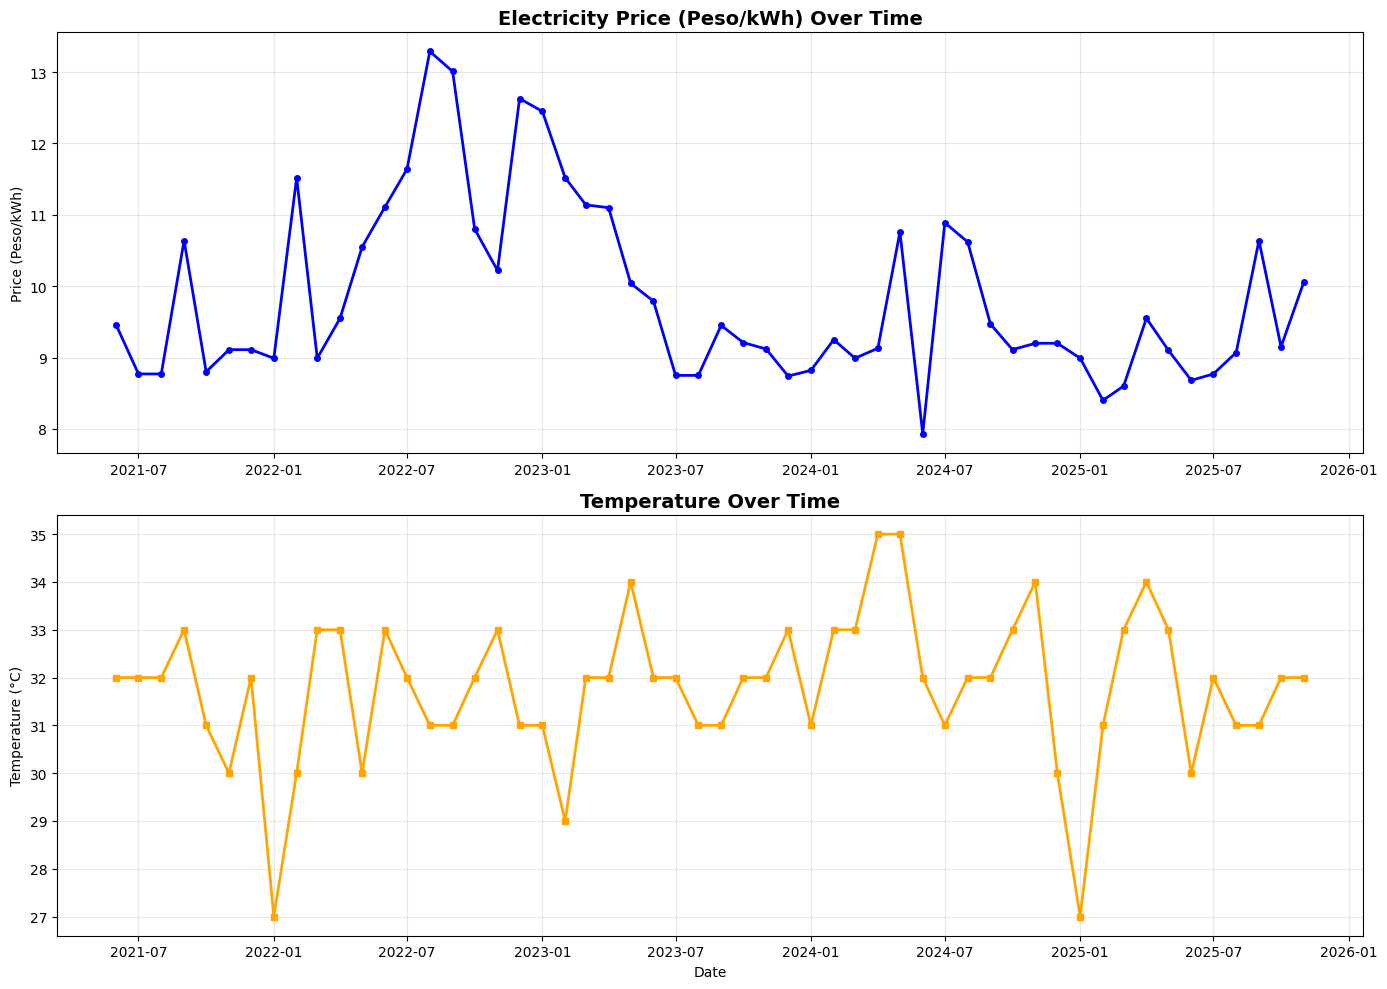

In [ ]:
# Plot the time series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Electricity price plot
axes[0].plot(df.index, df['peso_to_kWh'], marker='o', linewidth=2, markersize=4, color='blue')
axes[0].set_title('Electricity Price (Peso/kWh) Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (Peso/kWh)')
axes[0].grid(True, alpha=0.3)

# Temperature plot
axes[1].plot(df.index, df['temperature'], marker='s', color='orange', linewidth=2, markersize=4)
axes[1].set_title('Temperature Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

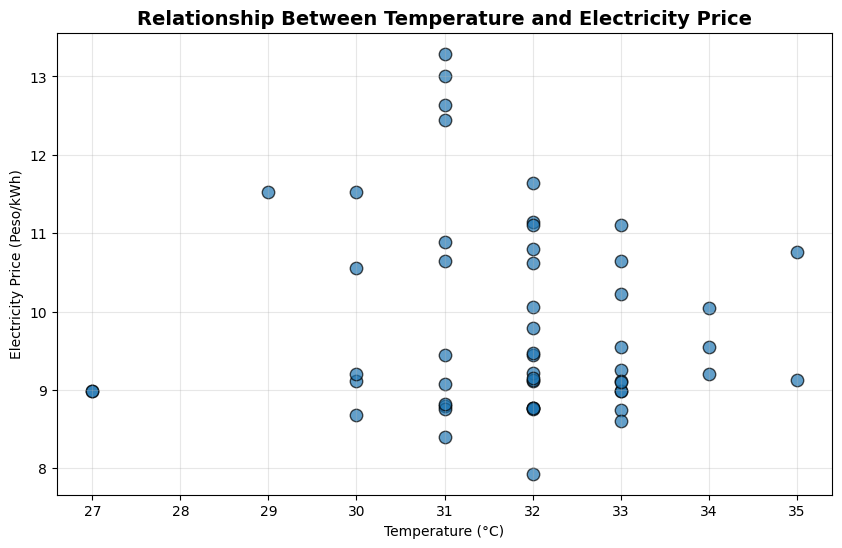

Correlation coefficient between temperature and electricity price: -0.0883
This indicates a weak negative correlation between temperature and electricity prices.


In [ ]:
# Scatter plot to visualize relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['temperature'], df['peso_to_kWh'], alpha=0.7, edgecolors='k', s=80)
plt.title('Relationship Between Temperature and Electricity Price', fontsize=14, fontweight='bold')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Price (Peso/kWh)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation coefficient
correlation = df['temperature'].corr(df['peso_to_kWh'])
print(f"Correlation coefficient between temperature and electricity price: {correlation:.4f}")

# Interpret correlation
if abs(correlation) > 0.7:
    strength = "strong"
elif abs(correlation) > 0.3:
    strength = "moderate"
else:
    strength = "weak"

if correlation > 0:
    direction = "positive"
else:
    direction = "negative"

print(f"This indicates a {strength} {direction} correlation between temperature and electricity prices.")


ADF Test for Electricity Price:
ADF Statistic: -3.6554
p-value: 0.0048
Critical Values:
   1%: -3.5602
   5%: -2.9179
   10%: -2.5968
Conclusion: Reject null hypothesis - Series is STATIONARY

ADF Test for Temperature:
ADF Statistic: -4.7504
p-value: 0.0001
Critical Values:
   1%: -3.5656
   5%: -2.9201
   10%: -2.5980
Conclusion: Reject null hypothesis - Series is STATIONARY


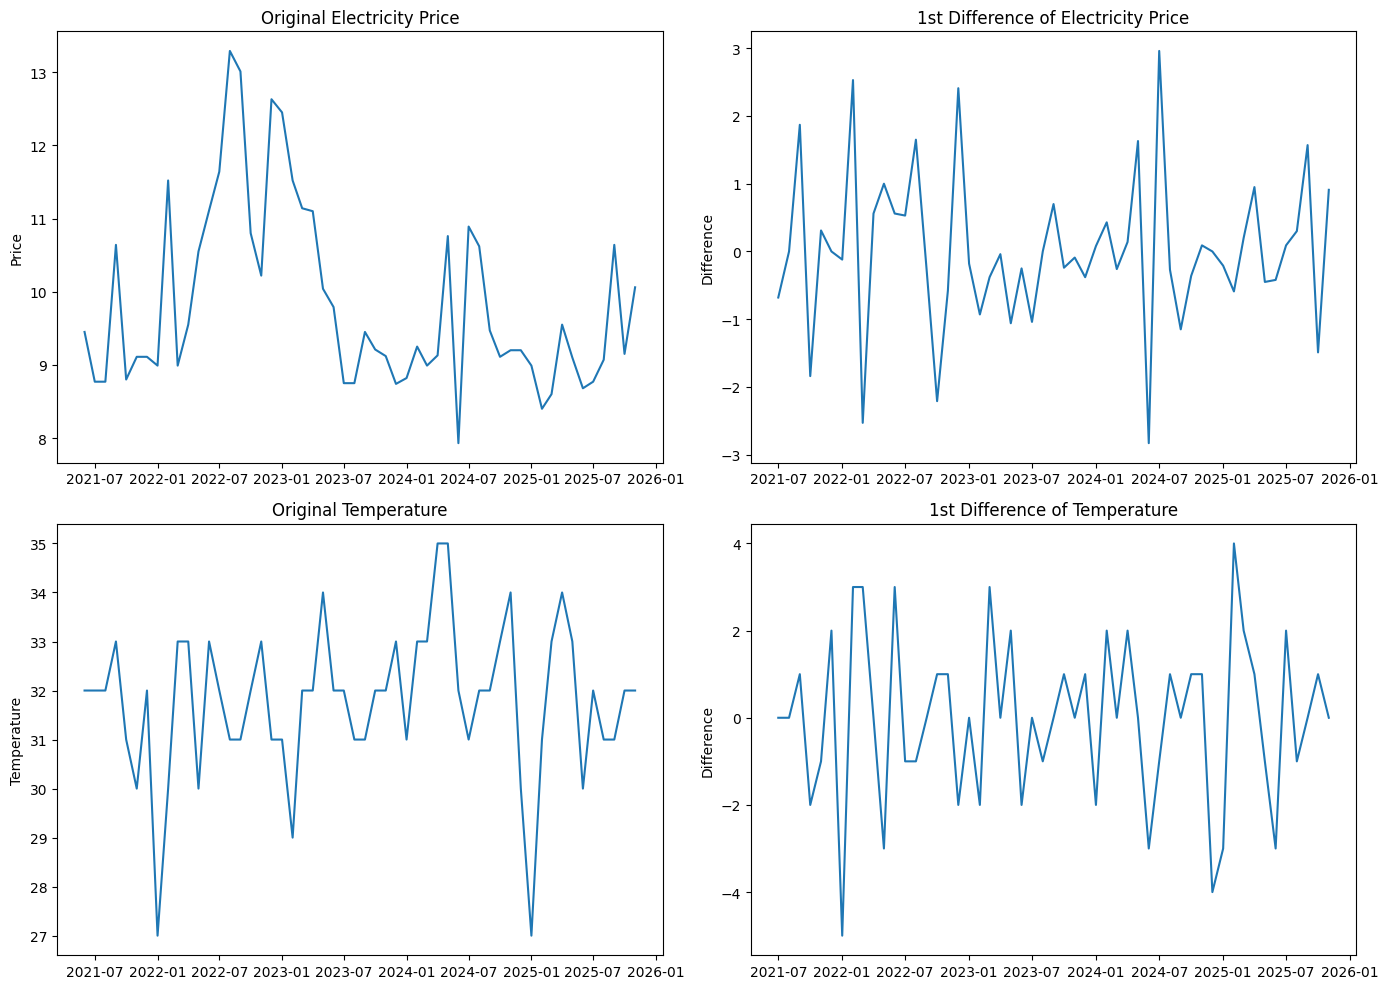

In [ ]:
def adf_test(timeseries, series_name="Series"):
    """Perform Augmented Dickey-Fuller test for stationarity."""
    print(f'\nADF Test for {series_name}:')
    print('=' * 40)

    result = adfuller(timeseries.dropna(), autolag='AIC')

    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Conclusion: Reject null hypothesis - Series is STATIONARY")
    else:
        print("Conclusion: Fail to reject null hypothesis - Series is NON-STATIONARY")

    return result

# Test stationarity of electricity price
price_adf_result = adf_test(df['peso_to_kWh'], "Electricity Price")

# Test stationarity of temperature
temp_adf_result = adf_test(df['temperature'], "Temperature")

# Plot original series and differenced series for visual inspection
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original electricity price
axes[0, 0].plot(df['peso_to_kWh'])
axes[0, 0].set_title('Original Electricity Price')
axes[0, 0].set_ylabel('Price')

# Differenced electricity price (1st difference)
axes[0, 1].plot(df['peso_to_kWh'].diff().dropna())
axes[0, 1].set_title('1st Difference of Electricity Price')
axes[0, 1].set_ylabel('Difference')

# Original temperature
axes[1, 0].plot(df['temperature'])
axes[1, 0].set_title('Original Temperature')
axes[1, 0].set_ylabel('Temperature')

# Differenced temperature (1st difference)
axes[1, 1].plot(df['temperature'].diff().dropna())
axes[1, 1].set_title('1st Difference of Temperature')
axes[1, 1].set_ylabel('Difference')

plt.tight_layout()
plt.show()

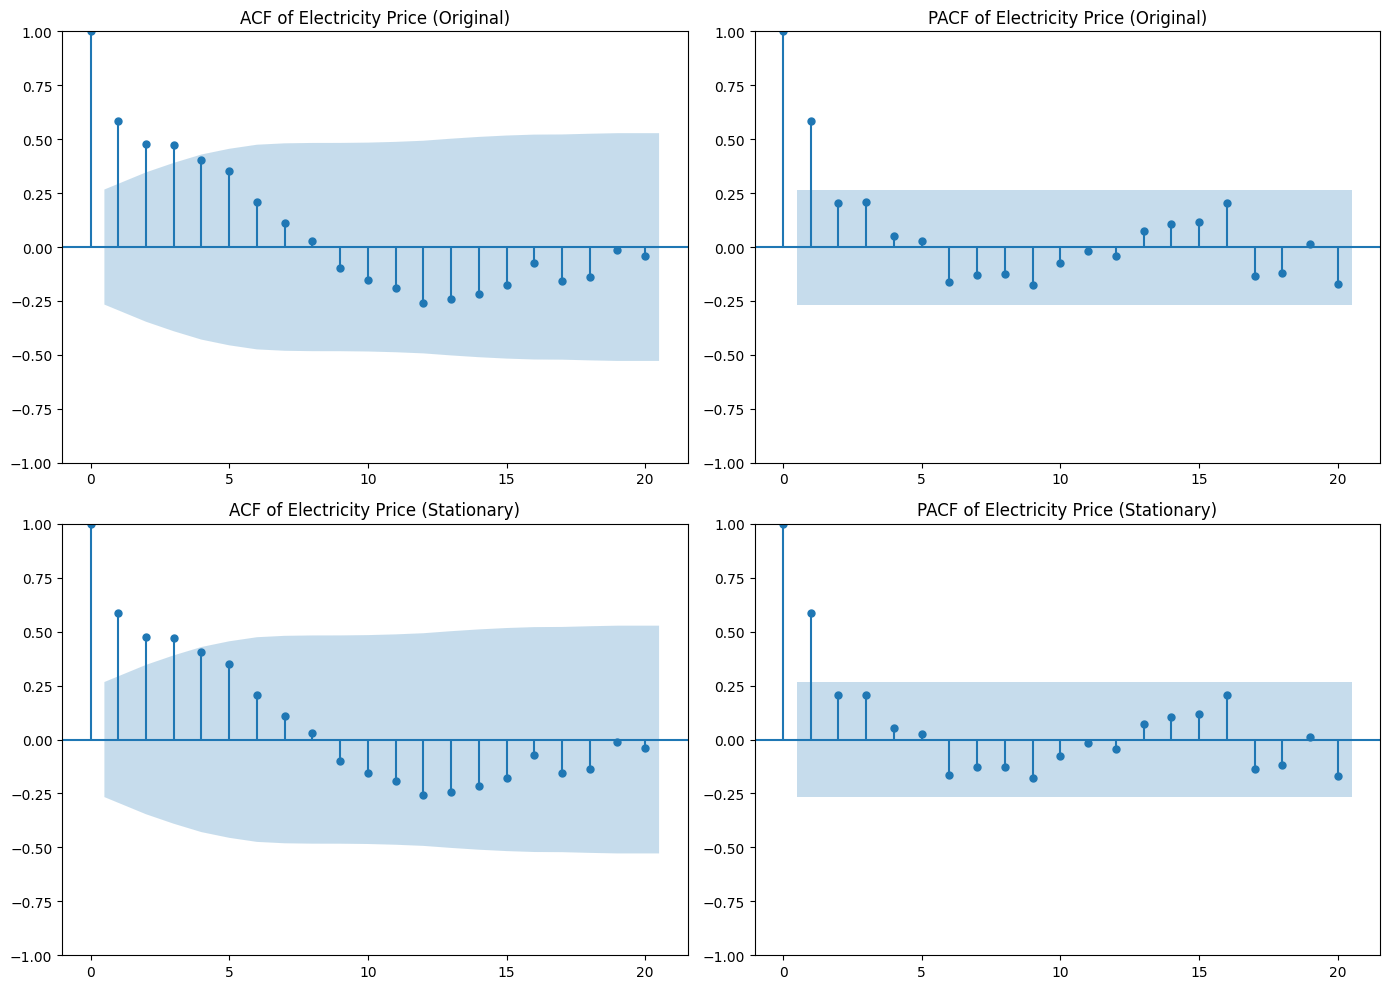

In [ ]:
# Plot ACF and PACF for electricity price (after differencing if needed)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF for original series
plot_acf(df['peso_to_kWh'], lags=20, ax=axes[0, 0])
axes[0, 0].set_title('ACF of Electricity Price (Original)')

# PACF for original series
plot_pacf(df['peso_to_kWh'], lags=20, ax=axes[0, 1])
axes[0, 1].set_title('PACF of Electricity Price (Original)')

# Check if differencing is needed (based on ADF test)
if price_adf_result[1] > 0.05:
    # Series is non-stationary, use differenced series
    price_diff = df['peso_to_kWh'].diff().dropna()

    plot_acf(price_diff, lags=20, ax=axes[1, 0])
    axes[1, 0].set_title('ACF of Electricity Price (1st Difference)')

    plot_pacf(price_diff, lags=20, ax=axes[1, 1])
    axes[1, 1].set_title('PACF of Electricity Price (1st Difference)')

    print("\nNote: Using differenced series for ARIMA modeling")
    print(f"ADF p-value for differenced series: {adfuller(price_diff)[1]:.4f}")
else:
    # Series is stationary, use original series
    plot_acf(df['peso_to_kWh'], lags=20, ax=axes[1, 0])
    axes[1, 0].set_title('ACF of Electricity Price (Stationary)')

    plot_pacf(df['peso_to_kWh'], lags=20, ax=axes[1, 1])
    axes[1, 1].set_title('PACF of Electricity Price (Stationary)')

plt.tight_layout()
plt.show()

In [ ]:
# =============================================
# PART 7: ARIMA MODEL SELECTION (NO EXOGENOUS VARIABLES)
# =============================================

# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"Training set: {len(train)} months ({train.index[0]} to {train.index[-1]})")
print(f"Test set: {len(test)} months ({test.index[0]} to {test.index[-1]})")

# Function to evaluate ARIMA model (NO exogenous variables)
def evaluate_arima_model(train_data, test_data, order):
    """Evaluate ARIMA model without exogenous variables."""
    try:
        # ARIMA model WITHOUT exogenous variable
        model = ARIMA(train_data['peso_to_kWh'], order=order)
        model_fit = model.fit()

        # Make predictions (no exog needed)
        predictions = model_fit.predict(
            start=len(train_data),
            end=len(train_data) + len(test_data) - 1
        )

        # Calculate metrics
        rmse = sqrt(mean_squared_error(test_data['peso_to_kWh'], predictions))
        mae = mean_absolute_error(test_data['peso_to_kWh'], predictions)
        mape = mean_absolute_percentage_error(test_data['peso_to_kWh'], predictions) * 100

        return {
            'order': order,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'model': model_fit
        }
    except Exception as e:
        print(f"Error with order {order}: {e}")
        return None

# Determine differencing order (d) based on ADF test
if price_adf_result[1] > 0.05:
    d = 1  # Need 1st differencing
else:
    d = 0  # Already stationary

print(f"\nBased on ADF test, using d = {d}")

# Try different ARIMA orders
orders_to_try = [
    (1, d, 1),
    (1, d, 0),
    (0, d, 1),
    (2, d, 2),
    (1, d, 2),
    (2, d, 1)
]

print("\nEvaluating ARIMA models (NO temperature/exogenous variables)...")
arima_results = []  # This will store ARIMA results
for order in orders_to_try:
    result = evaluate_arima_model(train, test, order)
    if result:
        arima_results.append(result)
        print(f"Order {order}: AIC={result['aic']:.2f}, BIC={result['bic']:.2f}, RMSE={result['rmse']:.3f}")

# Find best model based on AIC
best_arima = min(arima_results, key=lambda x: x['aic'])  # This creates best_arima
print(f"\nBest ARIMA model: Order {best_arima['order']}")
print(f"AIC: {best_arima['aic']:.2f}, BIC: {best_arima['bic']:.2f}")
print(f"RMSE: {best_arima['rmse']:.3f}, MAE: {best_arima['mae']:.3f}")

Training set: 43 months (2021-06-01 00:00:00 to 2024-12-01 00:00:00)
Test set: 11 months (2025-01-01 00:00:00 to 2025-11-01 00:00:00)

Based on ADF test, using d = 0

Evaluating ARIMA models (NO temperature/exogenous variables)...
Order (1, 0, 1): AIC=132.96, BIC=140.01, RMSE=0.754
Order (1, 0, 0): AIC=133.62, BIC=138.90, RMSE=0.919
Order (0, 0, 1): AIC=138.84, BIC=144.12, RMSE=1.015
Order (2, 0, 2): AIC=135.71, BIC=146.28, RMSE=0.753
Order (1, 0, 2): AIC=134.95, BIC=143.76, RMSE=0.756
Order (2, 0, 1): AIC=134.96, BIC=143.77, RMSE=0.755

Best ARIMA model: Order (1, 0, 1)
AIC: 132.96, BIC: 140.01
RMSE: 0.754, MAE: 0.684



Evaluating ARIMAX models (with temperature as exogenous variable)...
Based on ADF test, using d = 0
Order (1, 0, 1): AIC=134.59, BIC=143.40, RMSE=0.776
Order (1, 0, 0): AIC=135.55, BIC=142.60, RMSE=0.924
Order (0, 0, 1): AIC=140.74, BIC=147.79, RMSE=1.026
Order (2, 0, 2): AIC=137.67, BIC=150.00, RMSE=0.758
Order (1, 0, 2): AIC=136.57, BIC=147.14, RMSE=0.775
Order (2, 0, 1): AIC=140.27, BIC=150.83, RMSE=1.040

Best ARIMAX model: Order (1, 0, 1)
AIC: 134.59, BIC: 143.40

Selected model: ARIMAX with order (1, 0, 1)
Note: Using temperature as exogenous variable

Residuals analysis:
Number of residuals: 11
Maximum lags for ACF: 10

ARIMAX MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:            peso_to_kWh   No. Observations:                   43
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -62.297
Date:                Wed, 10 Dec 2025   AIC                            134.594
Time:                      

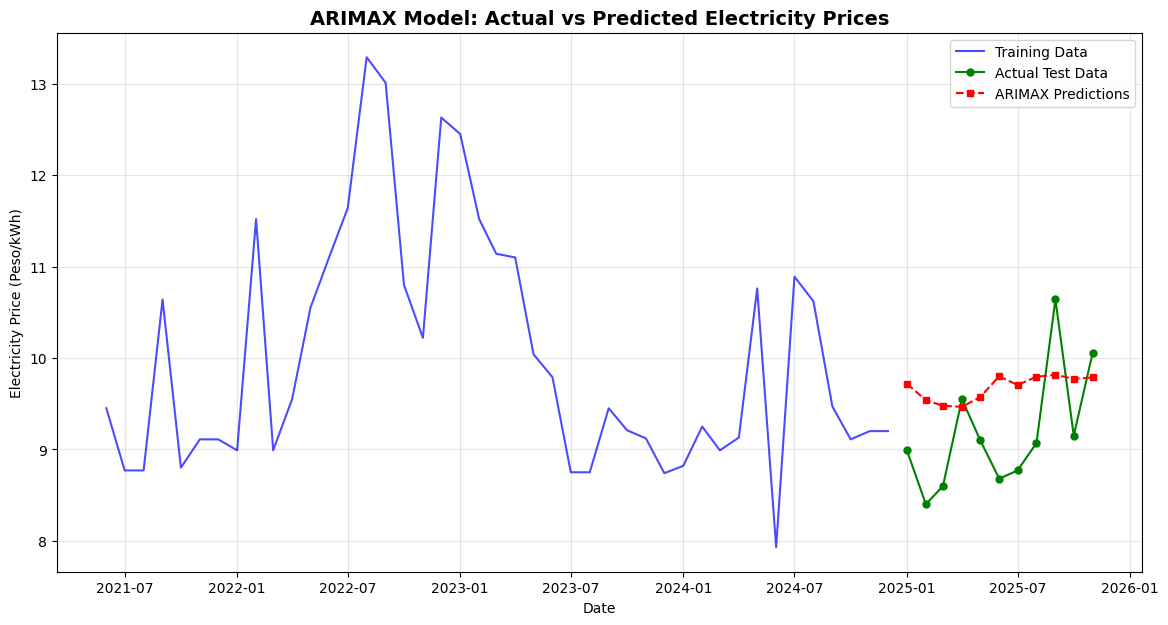

In [ ]:
# =============================================
# PART 7.1: ARIMAX MODEL VALIDATION AND FORECASTING
# =============================================

# First, we need to create the ARIMAX model evaluation function
def evaluate_arimax_model(train_data, test_data, order):
    """Evaluate ARIMAX model with given order (includes temperature as exogenous variable)."""
    try:
        # ARIMAX model WITH exogenous variable (temperature)
        model = ARIMA(train_data['peso_to_kWh'],
                     exog=train_data[['temperature']],  # Add temperature as exogenous
                     order=order)
        model_fit = model.fit()

        # Make predictions with exogenous variable from test set
        predictions = model_fit.predict(
            start=len(train_data),
            end=len(train_data) + len(test_data) - 1,
            exog=test_data[['temperature']]  # Include future temperature values
        )

        # Calculate metrics
        rmse = sqrt(mean_squared_error(test_data['peso_to_kWh'], predictions))
        mae = mean_absolute_error(test_data['peso_to_kWh'], predictions)
        mape = mean_absolute_percentage_error(test_data['peso_to_kWh'], predictions) * 100

        return {
            'order': order,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'model': model_fit
        }
    except Exception as e:
        print(f"Error with order {order}: {e}")
        return None

# Now evaluate ARIMAX models
print("\nEvaluating ARIMAX models (with temperature as exogenous variable)...")
arimax_results = []

# Determine differencing order (d) based on ADF test
if price_adf_result[1] > 0.05:
    d = 1  # Need 1st differencing
else:
    d = 0  # Already stationary

print(f"Based on ADF test, using d = {d}")

# Try different ARIMAX orders
orders_to_try = [
    (1, d, 1),
    (1, d, 0),
    (0, d, 1),
    (2, d, 2),
    (1, d, 2),
    (2, d, 1)
]

for order in orders_to_try:
    result = evaluate_arimax_model(train, test, order)
    if result:
        arimax_results.append(result)
        print(f"Order {order}: AIC={result['aic']:.2f}, BIC={result['bic']:.2f}, RMSE={result['rmse']:.3f}")

# Find best ARIMAX model based on AIC
best_arimax = min(arimax_results, key=lambda x: x['aic'])
print(f"\nBest ARIMAX model: Order {best_arimax['order']}")
print(f"AIC: {best_arimax['aic']:.2f}, BIC: {best_arimax['bic']:.2f}")

# =============================================
# Now run the ARIMAX validation
# =============================================

# Use the ARIMAX model
best_model = best_arimax  # Changed from best_arima to best_arimax
model_type = "ARIMAX"

print(f"\nSelected model: {model_type} with order {best_model['order']}")
print("Note: Using temperature as exogenous variable")

# Get predictions for visualization (WITH exogenous variable)
predictions = best_model['model'].predict(
    start=len(train),
    end=len(train) + len(test) - 1,
    exog=test[['temperature']]  # Include exogenous variable
)

# Ensure predictions align with test data
predictions.index = test.index

# Residual analysis
residuals = test['peso_to_kWh'] - predictions

# Calculate number of available residuals for ACF
n_residuals = len(residuals)
max_lags = min(20, n_residuals - 1)

print(f"\nResiduals analysis:")
print(f"Number of residuals: {n_residuals}")
print(f"Maximum lags for ACF: {max_lags}")

# Print model summary
print("\n" + "="*60)
print(f"{model_type} MODEL SUMMARY")
print("="*60)
print(best_model['model'].summary())

# Additional residual statistics
print("\n" + "="*60)
print("RESIDUAL STATISTICS")
print("="*60)
print(f"Mean of residuals: {residuals.mean():.6f}")
print(f"Standard deviation of residuals: {residuals.std():.6f}")
print(f"Root Mean Square Error (RMSE): {np.sqrt(np.mean(residuals**2)):.6f}")
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(residuals)):.6f}")

# Check for autocorrelation in residuals using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")
if dw_stat < 1.5:
    print("Warning: Positive autocorrelation in residuals (DW < 1.5)")
elif dw_stat > 2.5:
    print("Warning: Negative autocorrelation in residuals (DW > 2.5)")
else:
    print("No significant autocorrelation detected in residuals (1.5 < DW < 2.5)")

# Performance metrics on test set
print("\n" + "="*60)
print("MODEL PERFORMANCE ON TEST SET")
print("="*60)
print(f"Test RMSE: {best_model['rmse']:.4f}")
print(f"Test MAE: {best_model['mae']:.4f}")
print(f"Test MAPE: {best_model['mape']:.2f}%")
print(f"AIC: {best_model['aic']:.2f}")
print(f"BIC: {best_model['bic']:.2f}")

# =============================================
# ARIMAX-SPECIFIC VALIDATION
# =============================================

print("\n" + "="*60)
print("EXOGENOUS VARIABLE (TEMPERATURE) ANALYSIS")
print("="*60)

# Check temperature coefficient significance
model_params = best_model['model'].params
model_pvalues = best_model['model'].pvalues

# Find temperature-related parameters
temp_coeff_found = False
for param_name, param_value in model_params.items():
    if 'temperature' in param_name.lower():
        temp_coeff_found = True
        p_value = model_pvalues[param_name]
        print(f"\nTemperature coefficient found:")
        print(f"  Parameter: {param_name}")
        print(f"  Coefficient: {param_value:.6f}")
        print(f"  p-value: {p_value:.6f}")

        if p_value < 0.05:
            print(f"  → Statistically significant (p < 0.05)")
            print(f"  → Interpretation: For each 1°C increase in temperature,")
            print(f"    electricity price changes by {param_value:.6f} pesos/kWh")
        else:
            print(f"  → NOT statistically significant (p > 0.05)")
            print(f"  → Temperature may not be a useful predictor in this model")

if not temp_coeff_found:
    print("No temperature coefficient found in model parameters")
    print("Check if temperature was properly included as exogenous variable")

# =============================================
# COMPARISON WITH ARIMA BASELINE
# =============================================

print("\n" + "="*60)
print("COMPARISON: ARIMA vs ARIMAX")
print("="*60)

# Create baseline ARIMA model (without temperature) for comparison
# Using the same order as ARIMAX
baseline_arima = ARIMA(train['peso_to_kWh'], order=best_model['order']).fit()
baseline_predictions = baseline_arima.predict(
    start=len(train),
    end=len(train) + len(test) - 1
)

# Calculate baseline metrics
baseline_residuals = test['peso_to_kWh'] - baseline_predictions
baseline_rmse = sqrt(mean_squared_error(test['peso_to_kWh'], baseline_predictions))
baseline_mae = mean_absolute_error(test['peso_to_kWh'], baseline_predictions)
baseline_mape = mean_absolute_percentage_error(test['peso_to_kWh'], baseline_predictions) * 100

print(f"\nARIMA Model (without temperature):")
print(f"  Test RMSE: {baseline_rmse:.4f}")
print(f"  Test MAE:  {baseline_mae:.4f}")
print(f"  Test MAPE: {baseline_mape:.2f}%")
print(f"  AIC:       {baseline_arima.aic:.2f}")

print(f"\nARIMAX Model (with temperature):")
print(f"  Test RMSE: {best_model['rmse']:.4f}")
print(f"  Test MAE:  {best_model['mae']:.4f}")
print(f"  Test MAPE: {best_model['mape']:.2f}%")
print(f"  AIC:       {best_model['aic']:.2f}")

# Calculate improvement
rmse_improvement = ((baseline_rmse - best_model['rmse']) / baseline_rmse) * 100
mae_improvement = ((baseline_mae - best_model['mae']) / baseline_mae) * 100
mape_improvement = ((baseline_mape - best_model['mape']) / baseline_mape) * 100
aic_improvement = ((baseline_arima.aic - best_model['aic']) / baseline_arima.aic) * 100

print(f"\nImprovement with ARIMAX:")
print(f"  RMSE change: {rmse_improvement:+.2f}%")
print(f"  MAE change:  {mae_improvement:+.2f}%")
print(f"  MAPE change: {mape_improvement:+.2f}%")
print(f"  AIC change:  {aic_improvement:+.2f}%")

# Final assessment
print(f"\n" + "-"*60)
print("FINAL ASSESSMENT:")
print("-"*60)

if rmse_improvement > 0:
    print("✓ ARIMAX performs BETTER than ARIMA (lower error)")
else:
    print("✗ ARIMAX does NOT improve over ARIMA")

if temp_coeff_found and p_value < 0.05:
    print("✓ Temperature is statistically significant in the model")
else:
    print("✗ Temperature is NOT statistically significant")

    # =============================================
# VISUALIZATION 1: Actual vs Predicted
# =============================================

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['peso_to_kWh'], label='Training Data', color='blue', alpha=0.7)
plt.plot(test.index, test['peso_to_kWh'], label='Actual Test Data', color='green', marker='o', markersize=5)
plt.plot(test.index, predictions, label='ARIMAX Predictions', color='red', marker='s', markersize=5, linestyle='--')
plt.title('ARIMAX Model: Actual vs Predicted Electricity Prices', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Electricity Price (Peso/kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Residuals analysis:
Number of residuals: 11
Maximum lags for ACF: 10


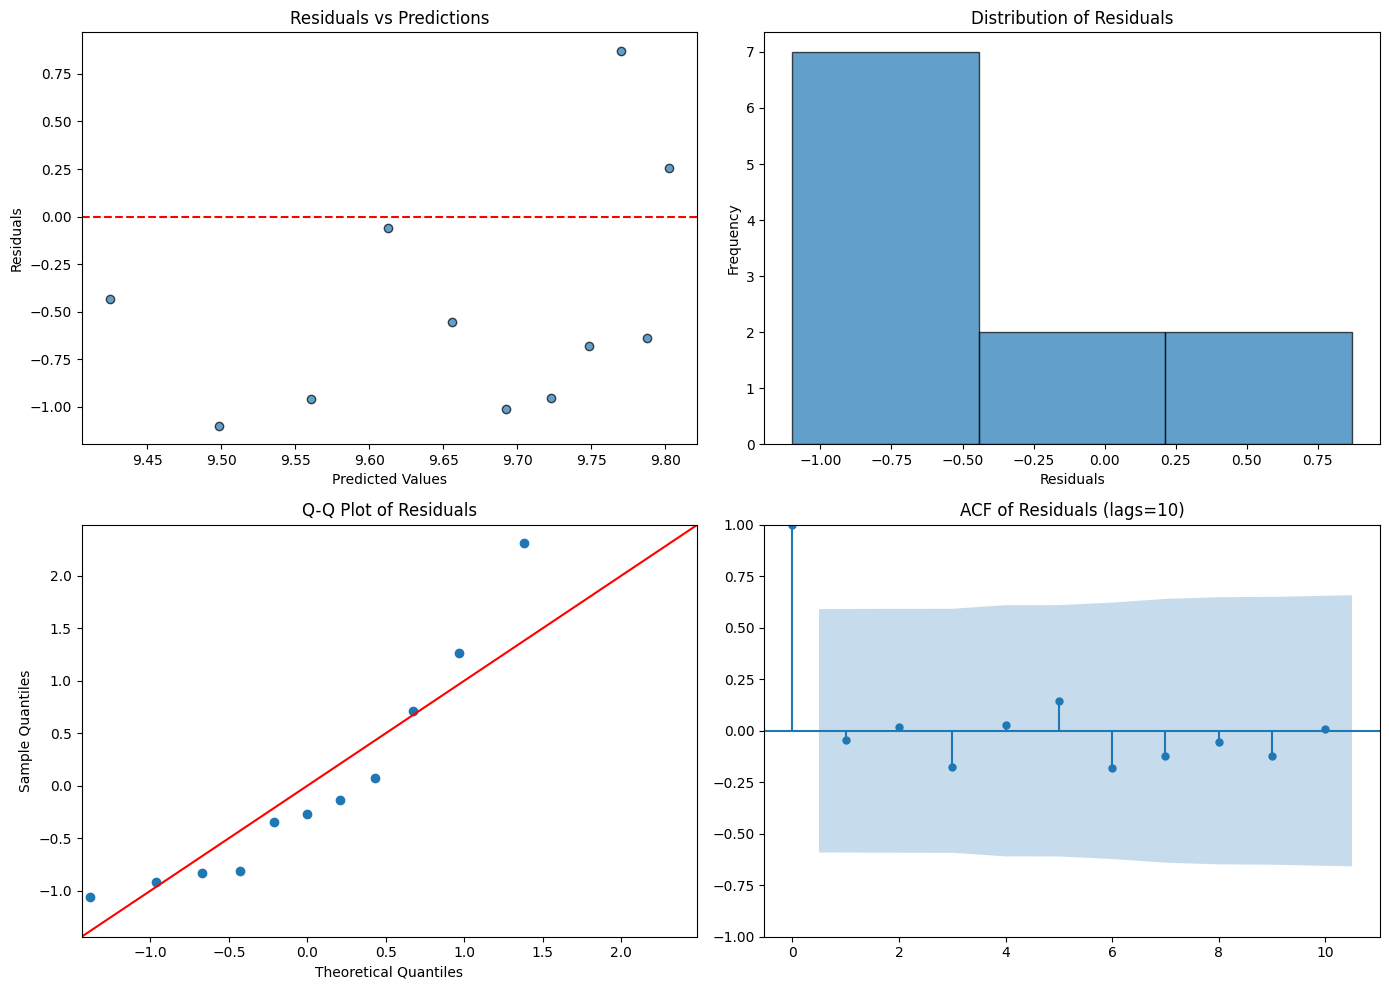


ARIMA MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:            peso_to_kWh   No. Observations:                   43
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -62.482
Date:                Wed, 10 Dec 2025   AIC                            132.965
Time:                        00:42:46   BIC                            140.010
Sample:                    06-01-2021   HQIC                           135.563
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8796      0.672     14.705      0.000       8.563      11.196
ar.L1          0.8372      0.126      6.649      0.000       0.590       1.084
ma.L1         -0.4308      0.18

In [ ]:
# =============================================
# PART 8: ARIMA MODEL VALIDATION AND FORECASTING
# =============================================

# Residual analysis
residuals = test['peso_to_kWh'] - predictions

# Calculate number of available residuals for ACF
n_residuals = len(residuals)
max_lags = min(20, n_residuals - 1)

print(f"\nResiduals analysis:")
print(f"Number of residuals: {n_residuals}")
print(f"Maximum lags for ACF: {max_lags}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual plot
axes[0, 0].scatter(predictions, residuals, alpha=0.7, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals vs Predictions')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')

# Residual distribution
axes[0, 1].hist(residuals, bins=min(10, len(residuals)//3), edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Q-Q plot
try:
    sm.qqplot(residuals, line='45', fit=True, ax=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f'Q-Q Plot Error:\n{str(e)}',
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Q-Q Plot of Residuals')

# Residual autocorrelation
try:
    plot_acf(residuals, lags=max_lags, ax=axes[1, 1])
    axes[1, 1].set_title(f'ACF of Residuals (lags={max_lags})')
except Exception as e:
    from statsmodels.tsa.stattools import acf
    try:
        acf_values = acf(residuals, nlags=max_lags)
        axes[1, 1].bar(range(len(acf_values)), acf_values, width=0.3)
        axes[1, 1].axhline(y=0, color='black', linewidth=0.5)
        axes[1, 1].axhline(y=1.96/np.sqrt(len(residuals)), color='red', linestyle='--', linewidth=0.8)
        axes[1, 1].axhline(y=-1.96/np.sqrt(len(residuals)), color='red', linestyle='--', linewidth=0.8)
        axes[1, 1].set_title(f'Manual ACF of Residuals (lags={max_lags})')
    except:
        axes[1, 1].text(0.5, 0.5, f'ACF Plot Error',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()

# Print model summary
print("\n" + "="*60)
print(f"{model_type} MODEL SUMMARY")
print("="*60)
print(best_model['model'].summary())

# Additional residual statistics
print("\n" + "="*60)
print("RESIDUAL STATISTICS")
print("="*60)
print(f"Mean of residuals: {residuals.mean():.6f}")
print(f"Standard deviation of residuals: {residuals.std():.6f}")
print(f"Root Mean Square Error (RMSE): {np.sqrt(np.mean(residuals**2)):.6f}")
print(f"Mean Absolute Error (MAE): {np.mean(np.abs(residuals)):.6f}")

# Check for autocorrelation in residuals using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")
if dw_stat < 1.5:
    print("Warning: Positive autocorrelation in residuals (DW < 1.5)")
elif dw_stat > 2.5:
    print("Warning: Negative autocorrelation in residuals (DW > 2.5)")
else:
    print("No significant autocorrelation detected in residuals (1.5 < DW < 2.5)")

Last date in dataset: 2025-11-01 00:00:00
Forecast start date: 2025-12-01 00:00:00

Forecast dates: ['2025-12', '2026-01', '2026-02', '2026-03', '2026-04', '2026-05']

ARIMA FORECAST (NO temperature/exogenous variables)


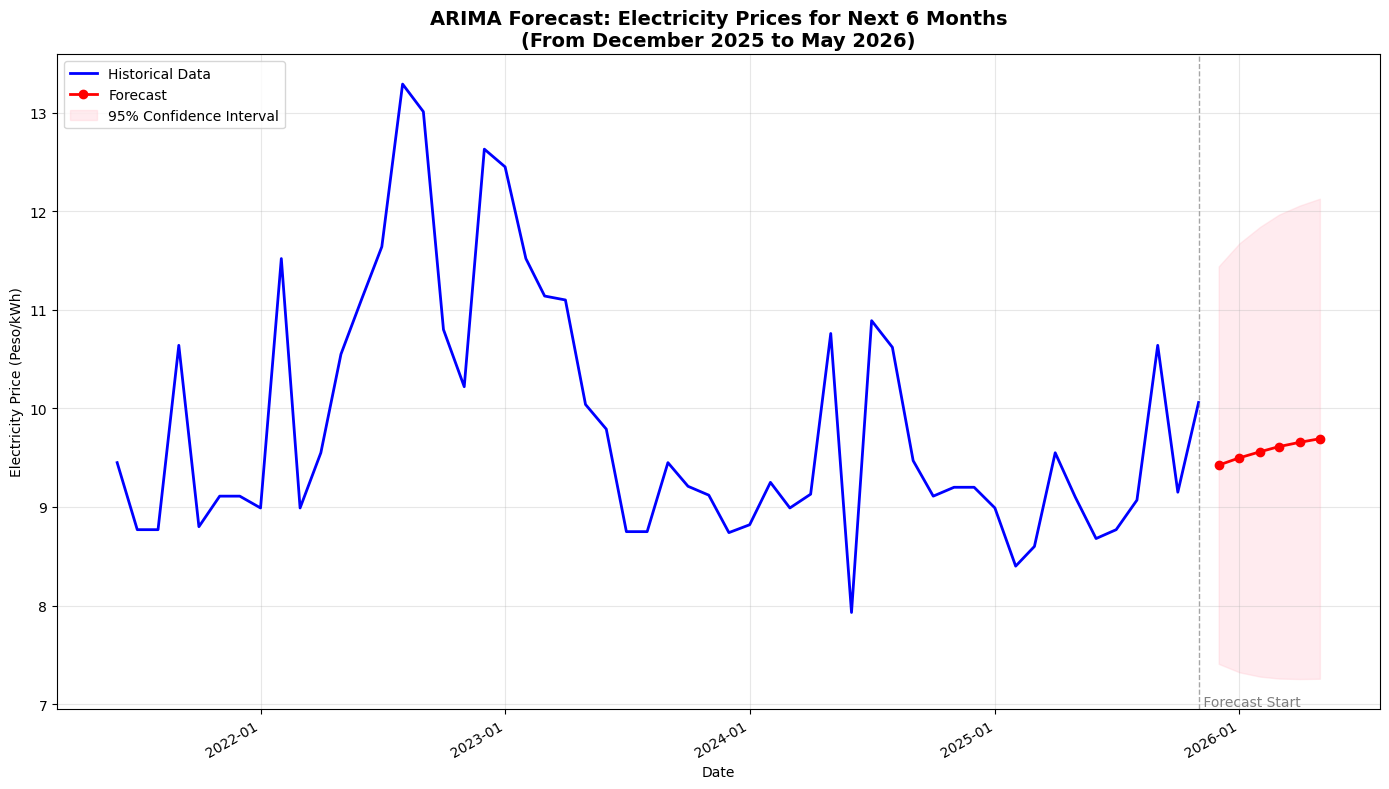


ARIMA FORECAST FOR December 2025 TO May 2026
  Month  Forecasted Price (Peso/kWh)  Lower 95% CI  Upper 95% CI
2025-12                        9.425         7.409        11.441
2026-01                        9.499         7.323        11.675
2026-02                        9.561         7.279        11.842
2026-03                        9.613         7.260        11.965
2026-04                        9.656         7.255        12.057
2026-05                        9.692         7.258        12.127

----------------------------------------------------------------------
Average forecasted price: 9.574 Peso/kWh
Minimum forecasted price: 9.425 Peso/kWh
Maximum forecasted price: 9.692 Peso/kWh


In [ ]:
# =============================================
# PART 9: ARIMA FORECASTING (NO EXOGENOUS VARIABLES)
# =============================================

# Forecast next 6 months starting from December 2025
forecast_months = 6

# Get the last date in our dataset
last_date = df.index[-1]
print(f"Last date in dataset: {last_date}")

# Calculate forecast start date (next month after last date)
forecast_start = last_date + pd.DateOffset(months=1)
print(f"Forecast start date: {forecast_start}")

# Generate forecast dates
forecast_dates = pd.date_range(
    start=forecast_start,
    periods=forecast_months,
    freq='MS'
)

print(f"\nForecast dates: {forecast_dates.strftime('%Y-%m').tolist()}")

# =============================================
# ARIMA FORECAST (no exogenous variables needed)
# =============================================

print("\n" + "="*70)
print("ARIMA FORECAST (NO temperature/exogenous variables)")
print("="*70)

# Forecast with ARIMA (no exog needed)
forecast = best_model['model'].get_forecast(steps=forecast_months)

# Get forecast results
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Set the index to our forecast dates
forecast_values.index = forecast_dates
confidence_intervals.index = forecast_dates

# =============================================
# PLOT FORECAST
# =============================================

plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(df.index, df['peso_to_kWh'],
         label='Historical Data',
         color='blue',
         linewidth=2)

# Plot forecast
plt.plot(forecast_values.index, forecast_values,
         label='Forecast',
         color='red',
         marker='o',
         markersize=6,
         linewidth=2)

# Plot confidence interval
plt.fill_between(forecast_values.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='pink',
                 alpha=0.3,
                 label='95% Confidence Interval')

# Add vertical line to separate history and forecast
plt.axvline(x=last_date,
           color='gray',
           linestyle='--',
           linewidth=1,
           alpha=0.7)
plt.text(last_date, plt.ylim()[0], ' Forecast Start',
         verticalalignment='bottom',
         horizontalalignment='left',
         color='gray',
         fontsize=10)

plt.title(f'ARIMA Forecast: Electricity Prices for Next {forecast_months} Months\n(From {forecast_dates[0].strftime("%B %Y")} to {forecast_dates[-1].strftime("%B %Y")})',
          fontsize=14,
          fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Electricity Price (Peso/kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Print forecast values
print("\n" + "="*70)
print(f"ARIMA FORECAST FOR {forecast_dates[0].strftime('%B %Y')} TO {forecast_dates[-1].strftime('%B %Y')}")
print("="*70)

forecast_df = pd.DataFrame({
    'Month': forecast_dates.strftime('%Y-%m'),
    'Forecasted Price (Peso/kWh)': forecast_values.round(3).values,
    'Lower 95% CI': confidence_intervals.iloc[:, 0].round(3).values,
    'Upper 95% CI': confidence_intervals.iloc[:, 1].round(3).values
})

print(forecast_df.to_string(index=False))

print("\n" + "-"*70)
print(f"Average forecasted price: {forecast_values.mean():.3f} Peso/kWh")
print(f"Minimum forecasted price: {forecast_values.min():.3f} Peso/kWh")
print(f"Maximum forecasted price: {forecast_values.max():.3f} Peso/kWh")

In [ ]:
# =============================================
# PART 10: FUTURE FORECASTING
# =============================================

print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print(f"\n1. DATA ANALYSIS:")
print(f"   - Total observations: {len(df)} months")
print(f"   - Date range: {df.index[0]} to {df.index[-1]}")
print(f"   - Average electricity price: {df['peso_to_kWh'].mean():.2f} Peso/kWh")
print(f"   - Average temperature: {df['temperature'].mean():.1f}°C")

print(f"\n2. CORRELATION ANALYSIS:")
print(f"   - Correlation coefficient: {correlation:.4f}")
print(f"   - Interpretation: {strength} {direction} correlation")

print(f"\n3. STATIONARITY TEST (ADF):")
print(f"   - Electricity price p-value: {price_adf_result[1]:.4f}")
print(f"   - Temperature p-value: {temp_adf_result[1]:.4f}")
print(f"   - Differencing required (d): {d}")

print(f"\n4. BEST MODEL:")
print(f"   - Model type: {model_type}")
print(f"   - Order (p,d,q): {best_model['order']}")
print(f"   - AIC: {best_model['aic']:.2f}")
print(f"   - BIC: {best_model['bic']:.2f}")

print(f"\n5. MODEL PERFORMANCE ON TEST SET:")
print(f"   - RMSE: {best_model['rmse']:.3f}")
print(f"   - MAE: {best_model['mae']:.3f}")
print(f"   - MAPE: {best_model['mape']:.2f}%")

print(f"\n6. FORECAST SUMMARY:")
print(f"   - Forecast period: {forecast_months} months")
print(f"   - Average forecasted price: {forecast_values.mean():.3f} Peso/kWh")
print(f"   - Minimum forecasted price: {forecast_values.min():.3f} Peso/kWh")
print(f"   - Maximum forecasted price: {forecast_values.max():.3f} Peso/kWh")

print(f"\n7. RESIDUAL ANALYSIS:")
print(f"   - Mean of residuals: {residuals.mean():.4f}")
print(f"   - Standard deviation of residuals: {residuals.std():.4f}")
print(f"   - Durbin-Watson statistic: {dw_stat:.4f}")

print("\n" + "="*70)
print("CONCLUSION")
print("="*70)
print("\nThe analysis demonstrates that:")
print(f"1. Temperature shows a {strength} {direction} correlation with electricity prices")
print(f"2. The {model_type} model with order {best_model['order']} effectively captures the time-series patterns")
print(f"3. The model achieved an RMSE of {best_model['rmse']:.3f} and MAPE of {best_model['mape']:.2f}% on test data")
print(f"4. The model can be used for short-term forecasting of electricity prices")
print("5. Regular model updating is recommended for maintaining accuracy")
print(f"6. Future forecasts suggest electricity prices ranging from {forecast_values.min():.3f} to {forecast_values.max():.3f} Peso/kWh")


FINAL RESULTS SUMMARY

1. DATA ANALYSIS:
   - Total observations: 54 months
   - Date range: 2021-06-01 00:00:00 to 2025-11-01 00:00:00
   - Average electricity price: 9.84 Peso/kWh
   - Average temperature: 31.8°C

2. CORRELATION ANALYSIS:
   - Correlation coefficient: -0.0883
   - Interpretation: weak negative correlation

3. STATIONARITY TEST (ADF):
   - Electricity price p-value: 0.0048
   - Temperature p-value: 0.0001
   - Differencing required (d): 0

4. BEST MODEL:
   - Model type: ARIMA
   - Order (p,d,q): (1, 0, 1)
   - AIC: 132.96
   - BIC: 140.01

5. MODEL PERFORMANCE ON TEST SET:
   - RMSE: 0.754
   - MAE: 0.684
   - MAPE: 7.60%

6. FORECAST SUMMARY:
   - Forecast period: 6 months
   - Average forecasted price: 9.574 Peso/kWh
   - Minimum forecasted price: 9.425 Peso/kWh
   - Maximum forecasted price: 9.692 Peso/kWh

7. RESIDUAL ANALYSIS:
   - Mean of residuals: -0.4788
   - Standard deviation of residuals: 0.6111
   - Durbin-Watson statistic: 1.1621

CONCLUSION

The analy